# Workflow to automate passing wavefunction files to AimqbCalculation

Though not explicitly directly integrated with AIMAll software, `aiida-aimall` provides a workchain to take a SMILES string of a substituent as input, and generate and run a Gaussian calculation. This is provided in part due to workflows used by the authors in automating creation of data for large numbers of substituents automatically. The `SmilesToGaussianWorkchain` provides this functionality. It uses the RDKit package to convert the SMILES input to a molecular geometry, and then provides that to the Gaussian calculation.

The SMILES provides should have exactly one asterisk indicating the point of attachment of the substituent to the substrate. **In the generated geometry, this \* will be replaced with a hydrogen.** For example a valid input SMILES is "\*C" for a methyl group, but a methylene group with SMILES "\*C\*" or methane with SMILES "C" are invalid SMILES for input in this `WorkChain`. If such inputs are passed, an exception will be raised.

## Setting up the calculation

In [4]:
from aiida import load_profile
from aiida.plugins import WorkflowFactory
from aiida.orm import Str, load_code, Dict
from aiida.engine import submit

load_profile()
SmilestoGaussianWorkchain = WorkflowFactory('aimall.smitog16')
builder = SmilestoGaussianWorkchain.get_builder()
# methyl group
builder.smiles = Str('*C')
builder.gaussian_parameters = Dict(
            {
                "link0_parameters": {
                    "%chk": "aiida.chk",
                    "%mem": "3200MB",  # Currently set to use 8000 MB in .sh files
                    "%nprocshared": 4,
                },
                "functional": "wb97xd",
                "basis_set": "aug-cc-pvtz",
                "charge": 0,
                "multiplicity": 1,
                "route_parameters": {"opt": None, "Output": "WFX"},
                "input_parameters": {"output.wfx": None},
            }
)
builder.gaussian_code = load_code('gaussian@localhost')
builder.metadata.options.additional_retrieve_list = ['output.wfx']
submit(builder)

/Users/chemlab/anaconda3/envs/aiida/lib/python3.12/site-packages/aiida/storage/psql_dos/backend.py:271: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed
  with session.begin_nested() as savepoint:


AttributeError: 'ProcessBuilderNamespace-2d5928c9-8747-4b5c-9feb-c7ab84bb8039' object has no attribute 'options'

## Examining the output

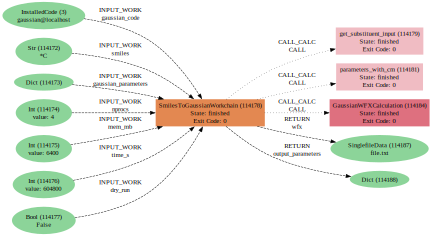

In [2]:
from aiida.orm import load_node
from aiida.tools.visualization import Graph

workchain_node = load_node(114178)
graph = Graph(graph_attr={"size": "6,6!", "rankdir": "LR"})
graph.add_incoming(workchain_node.uuid,
                   annotate_links="both")
graph.add_outgoing(workchain_node.uuid,
                   annotate_links="both")
graph.graphviz


## Additional Options

`SmilesToGaussianWorkchain` takes some additional inputs not provided above. Aside from the runtime parameters seen in the provenance graph generated, one can optionally provide a wavefunction group as `wfxgroup`. This will store the wavefunction file in the provided group. This is useful for use with the controllers, which scan for inputs to submit from given groups. This functionality will be covered in another tutorial.